# <아파트 실거래가 데이터를 활용한 미래 가격 예측>

## 분석 설계
### 1. 문제 인식
* 부동산 투자에 앞서 미래 가격 상승이 예상되는 지역 선정 필요
* 가격 상승을 주도하는 강남 아파트 가격과 유사한 패턴으로 상승할 만한 지역 탐생 필요

### 2. 가설 설정
* 가설 1: 서울 전체 아파트와 강남 아파트의 가격은 변화하는 양상이 다를 것이다.
* 가설 2: 강남 아파트의 가격 변화를 따라서 후행적으로 가격이 변화하는 지역이 있을 것이다.

---
## 데이터 전처리
### 3. 가설을 검정할 데이터 준비, 변수 설계  
* 데이터 : 아파트 매매 실거래가 데이터(공공데이터)

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
df <- read.csv('apt_data_2010_2020.csv')

In [3]:
str(df)

'data.frame':	807353 obs. of  28 variables:
 $ 거래금액            : int  100000 110000 26500 30000 25900 25300 25000 27900 27800 26800 ...
 $ 건축년도            : int  2008 2004 2005 1999 1993 1992 1993 1992 1992 1993 ...
 $ 년                  : int  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ 도로명              : chr  "사직로8길" "경희궁2길" "율곡로2길" "혜화로3길" ...
 $ 도로명건물본번호코드: int  4 5 7 5 198 19 198 19 19 198 ...
 $ 도로명건물부번호코드: int  0 5 0 0 0 0 0 0 0 0 ...
 $ 도로명시군구코드    : int  11110 11110 11110 11110 11110 11110 11110 11110 11110 11110 ...
 $ 도로명일련번호코드  : int  3 1 1 2 2 1 2 1 1 2 ...
 $ 도로명지상지하코드  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 도로명코드          : int  4100135 4100005 4100234 4100545 4100020 4100065 4100020 4100065 4100065 4100020 ...
 $ 법정동              : chr  "사직동" "내수동" "수송동" "명륜2가" ...
 $ 법정동본번코드      : int  9 110 85 237 703 702 703 702 702 703 ...
 $ 법정동부번코드      : int  0 15 0 0 0 0 0 0 0 0 ...
 $ 법정동시군구코드    : int  11110 11110 11110 11110 11110 11110 11110 11110 11110 11110 ...
 $

* 데이터 처리

In [4]:
df$거래금액 <- gsub(',', '', df$거래금액) %>% as.integer()
df$법정동 <- gsub(' ', '', df$법정동)

* 변수 추가
    * 연/분기 정보(ex. 2010Q1, 2010Q2 ...) : 월별 데이터보다 변동성이 적은 분기별로 보기 위함
    * 평수, 평단가(1평 = 약 3.3제곱미터)

In [5]:
df$qrt <- ifelse(df$월 < 4, 'Q1',
                ifelse(df$월 < 7, 'Q2',
                      ifelse(df$월 < 10, 'Q3', 'Q4')))
df$yyyyqrt <- paste0(df$년, df$qrt)
df$평수 <- round(df$전용면적 / 3.3)
df$평단가 <- df$거래금액 / df$평수

In [6]:
str(df)

'data.frame':	807353 obs. of  28 variables:
 $ 거래금액            : int  100000 110000 26500 30000 25900 25300 25000 27900 27800 26800 ...
 $ 건축년도            : int  2008 2004 2005 1999 1993 1992 1993 1992 1992 1993 ...
 $ 년                  : int  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ 도로명              : chr  "사직로8길" "경희궁2길" "율곡로2길" "혜화로3길" ...
 $ 도로명건물본번호코드: int  4 5 7 5 198 19 198 19 19 198 ...
 $ 도로명건물부번호코드: int  0 5 0 0 0 0 0 0 0 0 ...
 $ 도로명시군구코드    : int  11110 11110 11110 11110 11110 11110 11110 11110 11110 11110 ...
 $ 도로명일련번호코드  : int  3 1 1 2 2 1 2 1 1 2 ...
 $ 도로명지상지하코드  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 도로명코드          : int  4100135 4100005 4100234 4100545 4100020 4100065 4100020 4100065 4100065 4100020 ...
 $ 법정동              : chr  "사직동" "내수동" "수송동" "명륜2가" ...
 $ 법정동본번코드      : int  9 110 85 237 703 702 703 702 702 703 ...
 $ 법정동부번코드      : int  0 15 0 0 0 0 0 0 0 0 ...
 $ 법정동시군구코드    : int  11110 11110 11110 11110 11110 11110 11110 11110 11110 11110 ...
 $

---
## 4. 분석(가설 검정)
### 가설1 : 서울 전체 아파트와 강남 아파트의 가격은 변화하는 양상이 다를 것이다.
    * 서울 전체 아파트 / 강남 아파트 가격 변화 추세 비교 필요
        * 서울 전체 아파트 매매 추이
        * 강남 아파트 매매 추이

#### 서울 전체 아파트 매매 추이 : 분기별 평균 거래금액 시각화

In [7]:
df.1 <- df %>% group_by(yyyyqrt) %>% summarise(`평균평단가` = mean(`평단가`))

`summarise()` ungrouping output (override with `.groups` argument)



In [8]:
library(extrafont) 
font_import(pattern = "NanumGothic")

Registering fonts with R



Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n] y


Scanning ttf files in C:\WINDOWS\Fonts ...

Extracting .afm files from .ttf files...

C:\Windows\Fonts\NanumGothic.ttf
 : NanumGothic already registered in fonts database. Skipping.

C:\Windows\Fonts\NanumGothicBold.ttf
 : NanumGothicBold already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in C:/Users/gram/Documents/R/win-library/4.0/extrafontdb/metrics



In [9]:
library(ggplot2)
theme_set(theme_grey(base_family='NanumGothic')) # 그래프 내 폰트 설정

`geom_smooth()` using formula 'y ~ x'



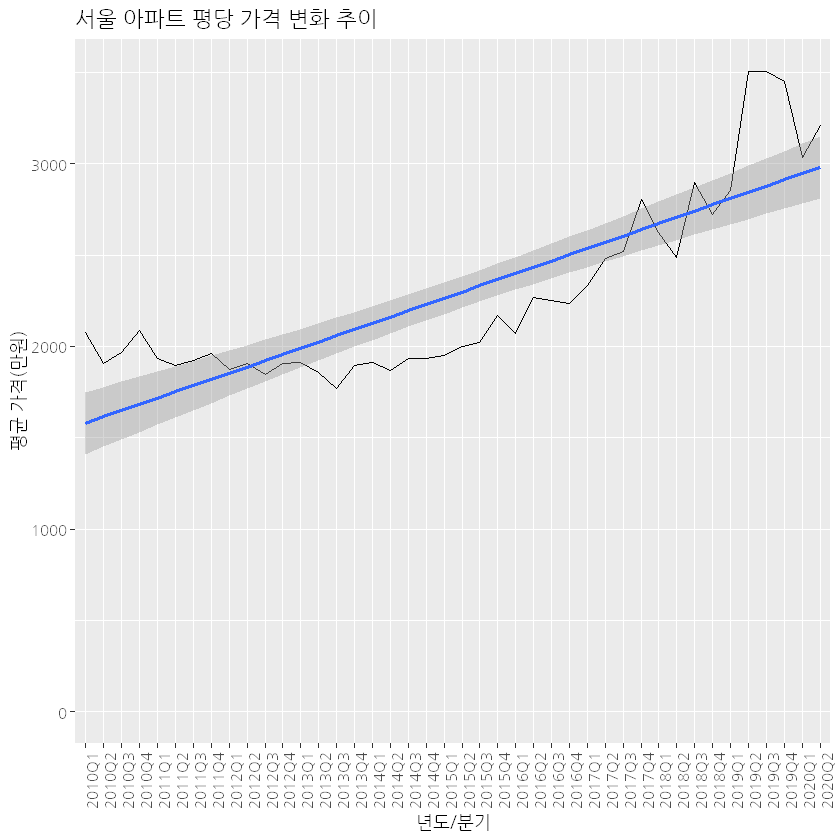

In [10]:
ggplot(df.1, aes(x = yyyyqrt, y = `평균평단가`, group = 1)) + # x축이 범주형 변수 -> 선형그래프를 그리려면 group = 1해줘야 함
    geom_line() + xlab("년도/분기") + ylab('평균 가격(만원)') +
    ggtitle("서울 아파트 평당 가격 변화 추이") +
    theme(axis.text.x = element_text(angle = 90)) + stat_smooth(method = 'lm') + # stat_smooth -> 그래프의 추세선
    ylim(0, max(df.1$평균평단가)) # y축의 범위

#### 강남 아파트 매매 가격 추이 : 반포동, 서초동, 삼성동, 압구정동 샘플링해서 분기별 평균 거래금액 시각화

In [14]:
# 강남 주요 동별 가격 변화 추이 비교
# 반포동
dong <- '반포동'
df.2 <- df %>% filter(`법정동` == dong)
df.2 <- df.2 %>% group_by(yyyyqrt) %>% summarise(`평균평단가` = mean(`평단가`))

df.2.plot <- ggplot(df.2, aes(x = yyyyqrt, y = `평균평단가`, group = 1)) +
    geom_line() + xlab("년도/분기") + ylab('평균 가격(만원)') +
    ggtitle(paste0(dong, " 아파트 평당 가격 변화 추이")) +
    theme(axis.text.x=element_text(angle=90)) + stat_smooth(method = 'lm') +
    ylim(0, max(df.2$평균평단가))

`summarise()` ungrouping output (override with `.groups` argument)



In [16]:
# 서초동
dong <- '서초동'
df.3 <- df %>% filter(`법정동` == dong)
df.3 <- df.3 %>% group_by(yyyyqrt) %>% summarise(`평균평단가` = mean(`평단가`))

df.3.plot <- ggplot(df.3, aes(x = yyyyqrt, y = `평균평단가`, group = 1)) +
    geom_line() + xlab("년도/분기") + ylab('평균 가격(만원)') +
    ggtitle(paste0(dong, " 아파트 평당 가격 변화 추이")) +
    theme(axis.text.x=element_text(angle=90)) + stat_smooth(method = 'lm') +
    ylim(0, max(df.3$평균평단가))

`summarise()` ungrouping output (override with `.groups` argument)



In [26]:
# 삼성동
dong <- '삼성동'
df.4 <- df %>% filter(`법정동` == dong)
df.4 <- df.4 %>% group_by(yyyyqrt) %>% summarise(`평균평단가` = mean(`평단가`))

df.4.plot <- ggplot(df.4, aes(x = yyyyqrt, y = `평균평단가`, group = 1)) +
    geom_line() + xlab("년도/분기") + ylab('평균 가격(만원)') +
    ggtitle(paste0(dong, " 아파트 평당 가격 변화 추이")) +
    theme(axis.text.x=element_text(angle=90)) + stat_smooth(method = 'lm') +
    ylim(0, max(df.4$평균평단가))

`summarise()` ungrouping output (override with `.groups` argument)



In [27]:
# 압구정동
dong <- '압구정동'
df.5 <- df %>% filter(`법정동` == dong)
df.5 <- df.5 %>% group_by(yyyyqrt) %>% summarise(`평균평단가` = mean(`평단가`))

df.5.plot <- ggplot(df.5, aes(x = yyyyqrt, y = `평균평단가`, group = 1)) +
    geom_line() + xlab("년도/분기") + ylab('평균 가격(만원)') +
    ggtitle(paste0(dong, " 아파트 평당 가격 변화 추이")) +
    theme(axis.text.x=element_text(angle=90)) + stat_smooth(method = 'lm') +
    ylim(0, max(df.5$평균평단가))

`summarise()` ungrouping output (override with `.groups` argument)



`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



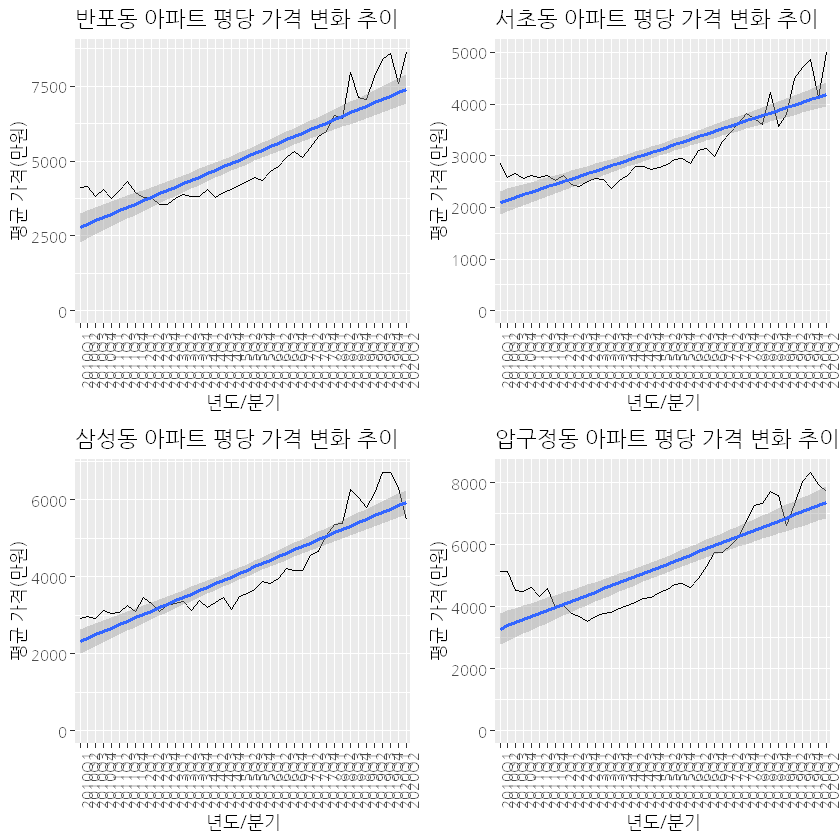

In [28]:
library(gridExtra)
grid.arrange(df.2.plot, df.3.plot, df.4.plot, df.5.plot, nrow = 2, ncol = 2)

---
### 가설2 : 강남 아파트의 가격 변화를 따라서 후행적으로 가격이 변화하는 지역이 있을 것이다. 
* 반포동 3개월 이전 까지의 추세와 유사한 지역 탐색
    * 계층적 군집분석을 통해 유사한 추세의 지역 확인

* 분석 내용
    * 가정 : 2020년 가격 하락세는 코로나 여파로 인한 일시적인 현상이며, 이전의 수준을 회복할 것이다.
        * 2020년 이전의 데이터로 반포동과 유사한 추세의 지역 탐색
    * 동별 가격 변화 추세로 계층적 군집분석
        * 각 동별 가격 추세의 상관관계를 유사도(거리) 행렬로 사용
        * 유사도 행렬로 계층적 군집분석

---
#### 계층적 군집분석을 통해 유사한 추세의 지역 확인 : 유사도 행렬 데이터셋 준비

In [29]:
library(dplyr)
df.fil <- df %>% filter(!yyyyqrt %in% c('2020Q1', '2020Q2')) # 2020년 데이터 제거

dong.list <- unique(df$법정동) # 동 리스트 추출

df.ts <- NULL
library(TTR)
for(i in dong.list) { # 동별/연분기별 이동평균 3 계산
    print(i)
    temp <- merge(i, df.fil %>% filter(`법정동` == i)  %>% 
        group_by(yyyyqrt) %>% 
        summarise(`평균평단가` = mean(`평단가`)) %>% 
        mutate(ma3 = runMean(`평균평단가`, 3)))
    df.ts <- rbind(df.ts, temp) %>% na.omit()
}

[1] "사직동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "내수동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "수송동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "명륜2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "창신동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "숭인동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "평창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "부암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신영동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "무악동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "통인동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "익선동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "인의동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "명륜1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당주동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "견지동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "이화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "행촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "구기동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신문로1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "필운동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신교동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "낙원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청운동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동숭동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "혜화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "회현동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "장충동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "을지로5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신당동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "흥인동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "황학동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "충무로4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "묵정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "산림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "중림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "인현동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "남산동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "필동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "예장동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "순화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "만리동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "남대문로5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "장충동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "후암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동자동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "산천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "원효로4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "효창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문배동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "한강로2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용산동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "한강로3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "이촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "이태원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "한남동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동빙고동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "서빙고동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "보광동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "한강로1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "원효로1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용문동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용산동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청파동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청파동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "하왕십리동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도선동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "마장동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "사근동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "행당동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "응봉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "금호동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "금호동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "금호동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "옥수동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성수동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성수동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "홍익동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "송정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용답동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "중곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "구의동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "광장동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "자양동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "화양동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "군자동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "능동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용두동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "제기동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "전농동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "답십리동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "장안동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청량리동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "회기동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "휘경동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "이문동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신설동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "면목동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상봉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "중화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "묵동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "망우동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신내동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성북동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "돈암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동소문동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼선동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼선동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동선동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동선동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "안암동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "안암동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "보문동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "정릉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "길음동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "종암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "하월곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상월곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "석관동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동소문동7가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼선동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "장위동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동소문동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동소문동6가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼선동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동선동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "안암동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "보문동6가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "미아동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "번동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "수유동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "우이동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "쌍문동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "방학동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도봉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "월계동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "공릉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "하계동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상계동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "중계동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "수색동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "녹번동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "불광동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "갈현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "구산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대조동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "응암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "역촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신사동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "증산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "진관동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "충정로3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "냉천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "천연동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "현저동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "북아현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "홍제동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "창천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "연희동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "홍은동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "북가좌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "남가좌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "충정로2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "합동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "아현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "공덕동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신공덕동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "용강동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "마포동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대흥동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "염리동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "노고산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신수동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "현석동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "창전동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "서교동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "합정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "망원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "연남동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "중동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상암동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "토정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상수동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "하중동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "목동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신월동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "염창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "등촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "화곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "가양동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "마곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "내발산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "공항동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "방화동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신도림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "구로동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "고척동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "개봉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "오류동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "궁동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "항동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "온수동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "가리봉동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "가산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "독산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "시흥동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동7가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동8가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "여의도동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문래동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문래동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문래동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문래동6가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양평동6가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신길동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문래동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "노량진동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상도동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상도1동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "본동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "흑석동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동작동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "사당동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대방동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신대방동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "봉천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신림동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "남현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "방배동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "양재동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "우면동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "잠원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "반포동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "서초동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "역삼동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "개포동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "청담동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼성동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "대치동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "논현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "압구정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "일원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "수서동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "도곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "잠실동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "풍납동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "송파동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "석촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "삼전동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "가락동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "문정동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "장지동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "방이동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "오금동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "거여동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "마천동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "명일동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "고덕동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상일동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "길동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "둔촌동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "암사동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성내동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "천호동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "강일동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "교북동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "충신동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "만리동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "회현동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "남창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "갈월동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "원효로3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신계동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신창동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "원효로2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동선동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "미근동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "동교동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "천왕동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "세곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "금호동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "보문동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "보문동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "당산동6가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "명륜3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동4가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동2가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "신원동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "연건동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "옥인동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "오장동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "상왕십리동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "성북동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "영등포동3가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "내곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "자곡동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "율현동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "필동1가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "충무로5가"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "홍파동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "효제동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "주성동"


`summarise()` ungrouping output (override with `.groups` argument)



[1] "평동"


`summarise()` ungrouping output (override with `.groups` argument)



In [31]:
# 아파트 매매가 매 분기 발생하지 않은 지역 제거
dong.list <- df.ts %>% group_by(x) %>% 
    summarise(cnt = n_distinct(yyyyqrt)) %>% 
    filter(cnt == 38)  %>% select(x)

df.ts.banpo <- df.ts %>% filter(x == '반포동')
df.ts <- df.ts %>% filter(x %in% dong.list$x, x != '반포동')

`summarise()` ungrouping output (override with `.groups` argument)



In [32]:
# 한 열에 한 동의 데이터가 들어가도록 배치
df.trend <- list()
for(i in dong.list$x) {
    print(i)
    temp <- df.ts %>% filter(x == i) %>% select(ma3) %>% as.matrix()
    df.trend[[i]] <- temp[,1]
}
df.trend <- as.data.frame(do.call(cbind,df.trend))

[1] "가락동"
[1] "가산동"
[1] "가양동"
[1] "갈현동"
[1] "강일동"
[1] "개봉동"
[1] "개포동"
[1] "거여동"
[1] "고덕동"
[1] "고척동"
[1] "공덕동"
[1] "공릉동"
[1] "공항동"
[1] "광장동"
[1] "구로동"
[1] "구산동"
[1] "구의동"
[1] "군자동"
[1] "궁동"
[1] "금호동1가"
[1] "금호동3가"
[1] "금호동4가"
[1] "길동"
[1] "길음동"
[1] "남가좌동"
[1] "내발산동"
[1] "노량진동"
[1] "녹번동"
[1] "논현동"
[1] "답십리동"
[1] "당산동"
[1] "당산동2가"
[1] "당산동3가"
[1] "당산동4가"
[1] "당산동5가"
[1] "대림동"
[1] "대방동"
[1] "대조동"
[1] "대치동"
[1] "대현동"
[1] "대흥동"
[1] "도곡동"
[1] "도림동"
[1] "도봉동"
[1] "도선동"
[1] "도원동"
[1] "도화동"
[1] "독산동"
[1] "돈암동"
[1] "동소문동4가"
[1] "둔촌동"
[1] "등촌동"
[1] "마곡동"
[1] "마장동"
[1] "마천동"
[1] "망우동"
[1] "망원동"
[1] "면목동"
[1] "명륜2가"
[1] "명일동"
[1] "목동"
[1] "무악동"
[1] "묵동"
[1] "문래동3가"
[1] "문래동4가"
[1] "문래동5가"
[1] "문래동6가"
[1] "문배동"
[1] "문정동"
[1] "반포동"
[1] "방배동"
[1] "방이동"
[1] "방학동"
[1] "방화동"
[1] "본동"
[1] "북가좌동"
[1] "북아현동"
[1] "불광동"
[1] "사당동"
[1] "사직동"
[1] "산천동"
[1] "삼선동2가"
[1] "삼성동"
[1] "상계동"
[1] "상도동"
[1] "상봉동"
[1] "상암동"
[1] "상월곡동"
[1] "상일동"
[1] "서교동"
[1] "서초동"
[1] "석관동"
[1] "석촌동"
[1] "성내동"
[1] "성산동"
[1] "성수동1가"
[1] "성수동

In [33]:
# 반포동 최근 3개월 데이터(마지막 행)를 제거
# 나머지 동들은 가장 오래된 3개월치 데이터(첫번째 행) 제거
# cbind로 붙임
df.trend.banpo <- df.ts.banpo[-38,] %>% select(ma3)
colnames(df.trend.banpo) <- '반포동'

df.trend <- df.trend[-1,]

df.trend <- cbind(df.trend, df.trend.banpo)

In [35]:
# 유사도 행렬(correlation)
df.cor <- cor(df.trend)
df.cor

,가락동,가산동,가양동,갈현동,강일동,개봉동,개포동,거여동,고덕동,고척동,...,홍제동,화곡동,화양동,황학동,회기동,효창동,후암동,휘경동,흑석동,반포동
가락동,1.0000000,-0.10353842,0.3909797,0.3519595,0.3874113,0.3826306,0.4010987,0.4344274,0.63682655,0.5184426,...,0.4779577,0.2724631,-0.01093534,0.4258113,0.3067451,0.5665343,0.4313237,0.4597235,0.4708448,0.4459534
가산동,-0.1035384,1.00000000,0.4359184,0.5319644,0.5393923,0.4731367,0.4182454,0.4071321,-0.03567109,0.3456646,...,0.4472010,0.4950535,0.58745746,0.4192997,0.5488932,0.5043422,0.3782186,0.4603764,0.4502251,0.4318553
가양동,0.3909797,0.43591836,1.0000000,0.9014539,0.9515470,0.9834107,0.9794822,0.9882902,0.69490608,0.9548837,...,0.9750323,0.9437238,0.83449160,0.9714378,0.9715694,0.8352302,0.9288343,0.9880649,0.9800799,0.9945730
갈현동,0.3519595,0.53196443,0.9014539,1.0000000,0.9542888,0.9226251,0.8908044,0.9300532,0.61524155,0.8450234,...,0.8962842,0.8888762,0.79268090,0.9131534,0.8892858,0.7878126,0.8337034,0.8985731,0.9369006,0.9104133
강일동,0.3874113,0.53939234,0.9515470,0.9542888,1.0000000,0.9472815,0.9150560,0.9623394,0.62678376,0.9089276,...,0.9369829,0.9179115,0.82803664,0.9427636,0.9513611,0.8339268,0.8653380,0.9519277,0.9734960,0.9569983
개봉동,0.3826306,0.47313674,0.9834107,0.9226251,0.9472815,1.0000000,0.9878051,0.9864053,0.68520379,0.9533639,...,0.9834938,0.9631924,0.82896203,0.9765230,0.9592454,0.8723307,0.9325857,0.9820792,0.9818210,0.9835551
개포동,0.4010987,0.41824544,0.9794822,0.8908044,0.9150560,0.9878051,1.0000000,0.9807063,0.72561055,0.9642165,...,0.9879625,0.9593684,0.81601036,0.9764127,0.9459463,0.8798145,0.9524610,0.9731650,0.9690913,0.9811318
거여동,0.4344274,0.40713213,0.9882902,0.9300532,0.9623394,0.9864053,0.9807063,1.0000000,0.75262059,0.9625906,...,0.9833776,0.9421343,0.79910503,0.9871309,0.9554417,0.8482136,0.9402233,0.9833703,0.9915180,0.9938341
고덕동,0.6368265,-0.03567109,0.6949061,0.6152415,0.6267838,0.6852038,0.7256106,0.7526206,1.00000000,0.7527924,...,0.7452283,0.5563751,0.30147044,0.7674072,0.5875536,0.6050027,0.8107928,0.7278453,0.7083986,0.7326149
고척동,0.5184426,0.34566455,0.9548837,0.8450234,0.9089276,0.9533639,0.9642165,0.9625906,0.75279245,1.0000000,...,0.9776120,0.9262839,0.78055808,0.9662624,0.9277601,0.9020630,0.9277364,0.9584867,0.9651252,0.9654291


#### 계층적 군집 분석

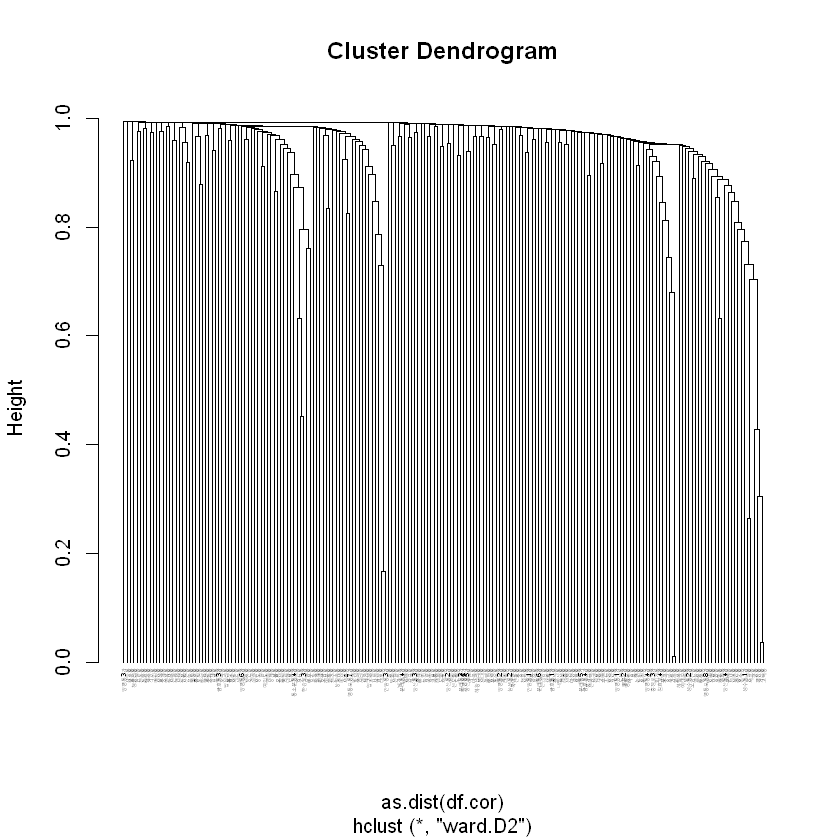

In [36]:
# 계층적 군집 분석
hc <- hclust(as.dist(df.cor), method = 'ward.D2')
plot(hc, hang = -1, cex = 0.35)

#### 반포동과 유사한 패턴을 보이는 지역 확인

In [59]:
# 반포동 / 나머지동 correlation
cor.banpo <- df.cor[197, 1:197] %>% as.data.frame() %>% arrange(desc(.))
cor.banpo

,.
,<dbl>
반포동,1.0000000
양평동5가,0.9979101
양평동3가,0.9969484
사당동,0.9960470
문래동6가,0.9959071
신도림동,0.9958734
문래동5가,0.9958646
일원동,0.9956802
영천동,0.9955833


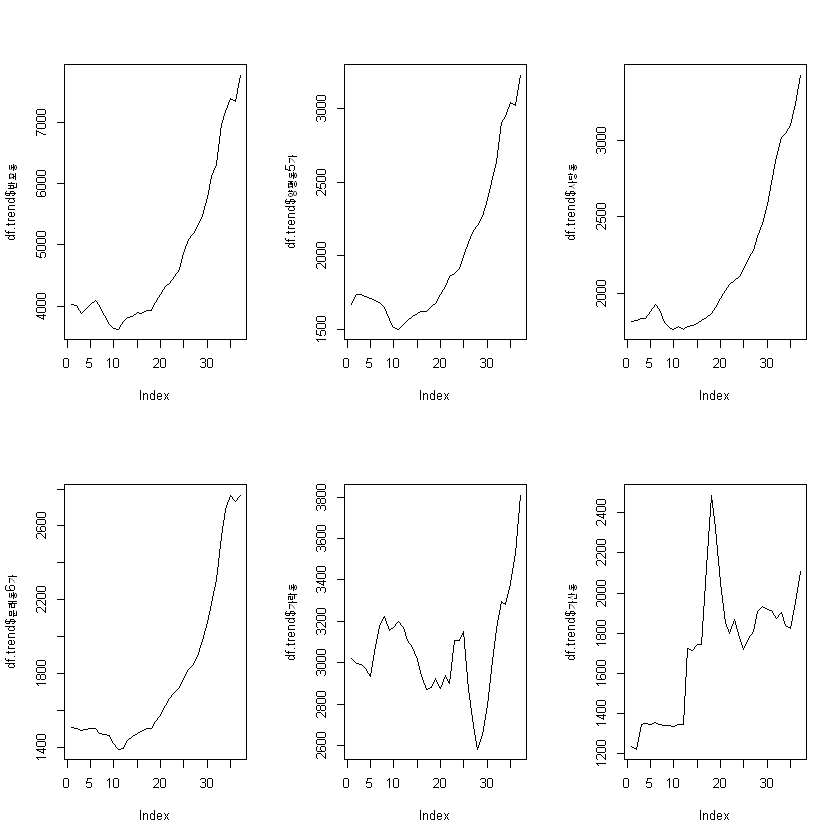

In [61]:
# 이동평균 3 그래프
par(mfrow=(c(2,3)))
plot(df.trend$반포동, type = 'l')
plot(df.trend$양평동5가, type = 'l')
plot(df.trend$사당동, type = 'l')
plot(df.trend$문래동6가, type = 'l')
plot(df.trend$가락동, type = 'l') # 유사도 2번째로 낮은 지역
plot(df.trend$가산동, type = 'l') # 유사도 가장 낮은 지역

### 결과의 활용방안 도출
* 반포동과 유사한 패턴의 지역 미래 가격 예측
    * 2020년 초 거래 가격의 수준으로 3개월 내 회복할 것으로 예측
    * 위 예측을 바탕으로 추가 자료를 조사하여 투자 지역 선정
   
   
* 특징적인 서울 아파트 가격 흐름의 파악
    * 계층적 군집 분석 결과로 어떻게 군집이 묶이는지 확인
    * 군집별 가격 흐름 파악